In [7]:
# Importing the required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader

# 1. Implementing Multi-Layer Perceptron using PyTorch

### a. Loading the IMDB dataset

In [8]:
imdb_data = pd.read_csv("IMDB.csv")

# Displaying info and structure of the dataset
dataset_overview = imdb_data.head(), imdb_data.info()
dataset_overview

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


(                                              review sentiment
 0  One of the other reviewers has mentioned that ...  positive
 1  A wonderful little production. <br /><br />The...  positive
 2  I thought this was a wonderful way to spend ti...  positive
 3  Basically there's a family where a little boy ...  negative
 4  Petter Mattei's "Love in the Time of Money" is...  positive,
 None)

### b. Preprocessing the Text Data using 'TfidfVectorizer' from scikit-learn to convert the text reviews into TF-IDF features. 

In [9]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limiting features to 5000
X = tfidf_vectorizer.fit_transform(imdb_data['review'])

### c. Encoding the Labels: Converting the sentiment labels('positive' and 'negative') into numerical values using 'LabelEncoder' from scikit-learn

In [10]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(imdb_data['sentiment'])  # 0 for 'negative', 1 for 'positive'

### d. Spliting the dataset into training, validation, and test sets. 

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [12]:
# Displaying the shape of the splits to confirm
{
    "Training set shape": X_train.shape,
    "Validation set shape": X_val.shape,
    "Test set shape": X_test.shape
}

{'Training set shape': (30000, 5000),
 'Validation set shape': (10000, 5000),
 'Test set shape': (10000, 5000)}

### e. Creating Dataset Class: Defining a custom 'Dataset' class for PyTorch to handle the data. 

In [13]:
# Define a custom Dataset class for PyTorch
class IMDBDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features.toarray(), dtype=torch.float32)  # Convert sparse matrix to dense
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [14]:
# Creating Dataset objects for training, validation, and testing sets
train_dataset = IMDBDataset(X_train, y_train)
val_dataset = IMDBDataset(X_val, y_val)
test_dataset = IMDBDataset(X_test, y_test)

### f. Creating DataLoaders: using 'DataLoader' from PyTorch to create iterators for the training, validation, and test sets.

In [15]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
#Checking the size of the first batch to confirm proper loading
sample_batch = next(iter(train_loader))
{
    "Batch features shape": sample_batch[0].shape,
    "Batch labels shape": sample_batch[1].shape
}

{'Batch features shape': torch.Size([64, 5000]),
 'Batch labels shape': torch.Size([64])}

# 2. Defining the architecture of MLP model using PyTorch

### a. Defining the MLP class by creating a class MLP that inherits from nn.Module. We will also define the network layers in the constructor.

In [17]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)  # Hidden layer
        self.relu = nn.ReLU()  # Activation function
        self.output = nn.Linear(hidden_size, num_classes)  # Output layer
    
    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x

### b. Initializing the model by specifying the number of features, hidden layer size and number of classes. 

In [18]:
input_size = 5000
hidden_size = 512
num_classes = 2

mlp_model = MLP(input_size, hidden_size, num_classes)

# Print the model architecture
print(mlp_model)

MLP(
  (hidden): Linear(in_features=5000, out_features=512, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=512, out_features=2, bias=True)
)


# 3. Training the MLP model using the training data and validating its performance on the Validation data. 

### a. Defining Loss function and Optimizer

In [19]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss for classification
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

### b. Initializing Metrics for Tracking

In [20]:
# Lists to store training and validation metrics over epochs
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

### c. Training Loop

In [21]:
num_epochs = 10  # Number of epochs for training

for epoch in range(num_epochs):
    # Training phase
    mlp_model.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for features, labels in train_loader:  # Iterate over training batches
        optimizer.zero_grad()  # Clear gradients
        outputs = mlp_model(features)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update model weights
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # Get predictions
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)


### d. Validation Loop

In [22]:
    # Validation phase
    mlp_model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():  # Disable gradient calculations for validation
        for features, labels in val_loader:
            outputs = mlp_model(features)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get predictions
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    val_loss = running_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch 10/10
Train Loss: 0.0023, Train Accuracy: 0.9999
Val Loss: 0.6887, Val Accuracy: 0.8721


# 4. Evaluating the trained MLP model on the test data and visualizing the training process. 

### a. Evaluating on Test Set

In [23]:
from sklearn.metrics import classification_report

# Test phase
mlp_model.eval()  # Set model to evaluation mode
correct_test = 0
total_test = 0
all_labels = []
all_predictions = []

with torch.no_grad():  # Disable gradient calculations for testing
    for features, labels in test_loader:
        outputs = mlp_model(features)
        _, predicted = torch.max(outputs, 1)  # Get predictions
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_accuracy = correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate and print classification report
print(classification_report(all_labels, all_predictions, target_names=label_encoder.classes_))


Test Accuracy: 0.8742
              precision    recall  f1-score   support

    negative       0.88      0.87      0.87      5000
    positive       0.87      0.88      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



### b. Visualizing training process

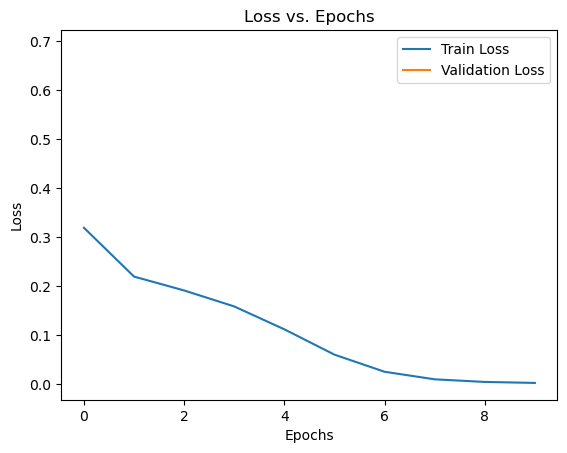

ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

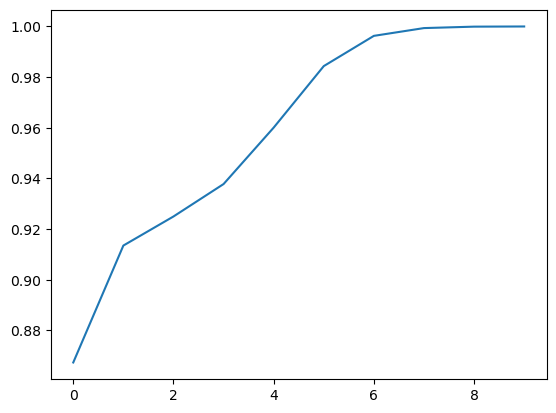

In [24]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.show()


# Plot training and validation accuracies
plt.figure()
plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()


# Bonus: Using Pre-trained BERT for Sentiment Analysis with Hugging Face

In [ ]:
#!pip install transformers
#!pip install datasets

python(75063) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(75066) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [ ]:
from transformers import pipeline
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

/Users/rupeshrangwani/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


### 1. Data Preparation

In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encoding sentiment labels using LabelEncoder
label_encoder = LabelEncoder()
imdb_data['encoded_sentiment'] = label_encoder.fit_transform(imdb_data['sentiment'])

# Splitting dataset into training, validation, and test sets (60%-20%-20%)
train_data, temp_data, train_labels, temp_labels = train_test_split(
    imdb_data['review'], imdb_data['encoded_sentiment'], test_size=0.4, random_state=42, stratify=imdb_data['encoded_sentiment']
)
val_data, test_data, val_labels, test_labels = train_test_split(
    temp_data, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

### 2. Pipeline Usage

In [26]:
from transformers import pipeline

# Initializing Hugging Face's pipeline with pre-trained model
sentiment_pipeline = pipeline('sentiment-analysis', model="nlptown/bert-base-multilingual-uncased-sentiment")

/Users/rupeshrangwani/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
python(75125) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

/Users/rupeshrangwani/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

/Users/rupeshrangwani/anaconda3/lib/python3.11/site-packages/transformers/modeling_utils.py:479: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_f

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

### 3. Text Truncation

In [27]:
# Truncate text reviews to avoid exceeding 512 token limit
def truncate_texts(texts, max_length=512):
    return [text[:max_length] for text in texts]

# Truncate validation and test data
val_data_truncated = truncate_texts(val_data)
test_data_truncated = truncate_texts(test_data)


### 4. Prediction Conversion

In [31]:
def batch_predict(pipeline, texts, batch_size=32):
    predictions = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        predictions.extend(pipeline(batch))  # Process a batch of texts
    return predictions


val_predictions = batch_predict(sentiment_pipeline, val_data_truncated, batch_size=32)
test_predictions = batch_predict(sentiment_pipeline, test_data_truncated, batch_size=32)


val_binary_preds = convert_sentiment_label(val_predictions)
test_binary_preds = convert_sentiment_label(test_predictions)


'def convert_sentiment_label(predictions):\n    binary_labels = []\n    for pred in predictions:\n        label = pred[\'label\']\n        # Converting 4/5 stars to positive (1) and others to negative (0)\n        binary_labels.append(1 if label in ["4 stars", "5 stars"] else 0)\n    return binary_labels\n\n# Making predictions and converting to binary labels\nval_predictions = sentiment_pipeline(val_data_truncated)\ntest_predictions = sentiment_pipeline(test_data_truncated)\n\nval_binary_preds = convert_sentiment_label(val_predictions)\ntest_binary_preds = convert_sentiment_label(test_predictions)\n'

### 5. Evaluation

In [32]:
#from sklearn.metrics import accuracy_score, classification_report

# Compute accuracy for validation and test sets
val_accuracy = accuracy_score(val_labels, val_binary_preds)
test_accuracy = accuracy_score(test_labels, test_binary_preds)

# Print evaluation metrics
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate classification report for test set
print("\nClassification Report for Test Set:")
print(classification_report(test_labels, test_binary_preds, target_names=["Negative", "Positive"]))

Validation Accuracy: 0.7961
Test Accuracy: 0.7867

Classification Report for Test Set:
              precision    recall  f1-score   support

    Negative       0.73      0.92      0.81      5000
    Positive       0.89      0.66      0.76      5000

    accuracy                           0.79     10000
   macro avg       0.81      0.79      0.78     10000
weighted avg       0.81      0.79      0.78     10000

